<a href="https://colab.research.google.com/github/tonytieger/w210-capstone-project/blob/master/action_recognition_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUMMARY
Our capstone project attempts to implement openly available research and literature around "Drowsy" driver detection through temporal and image recognition models.

#Challenge


The challenge of detecting drowsiness for an individual is really complicated. Especially because being "drowsy" is really subjective and different people have a different way of reacting to the body becoming tired and drowsy i.e. some people yawn, some people have various eye movements. Capturing and generalizing features across the whole dataset and training a model to detect that is a very challenging issue. 

## Dataset and approach
We are using the UTA RLDD video dataset (~180 videos with drowsy and alert facial expressions)

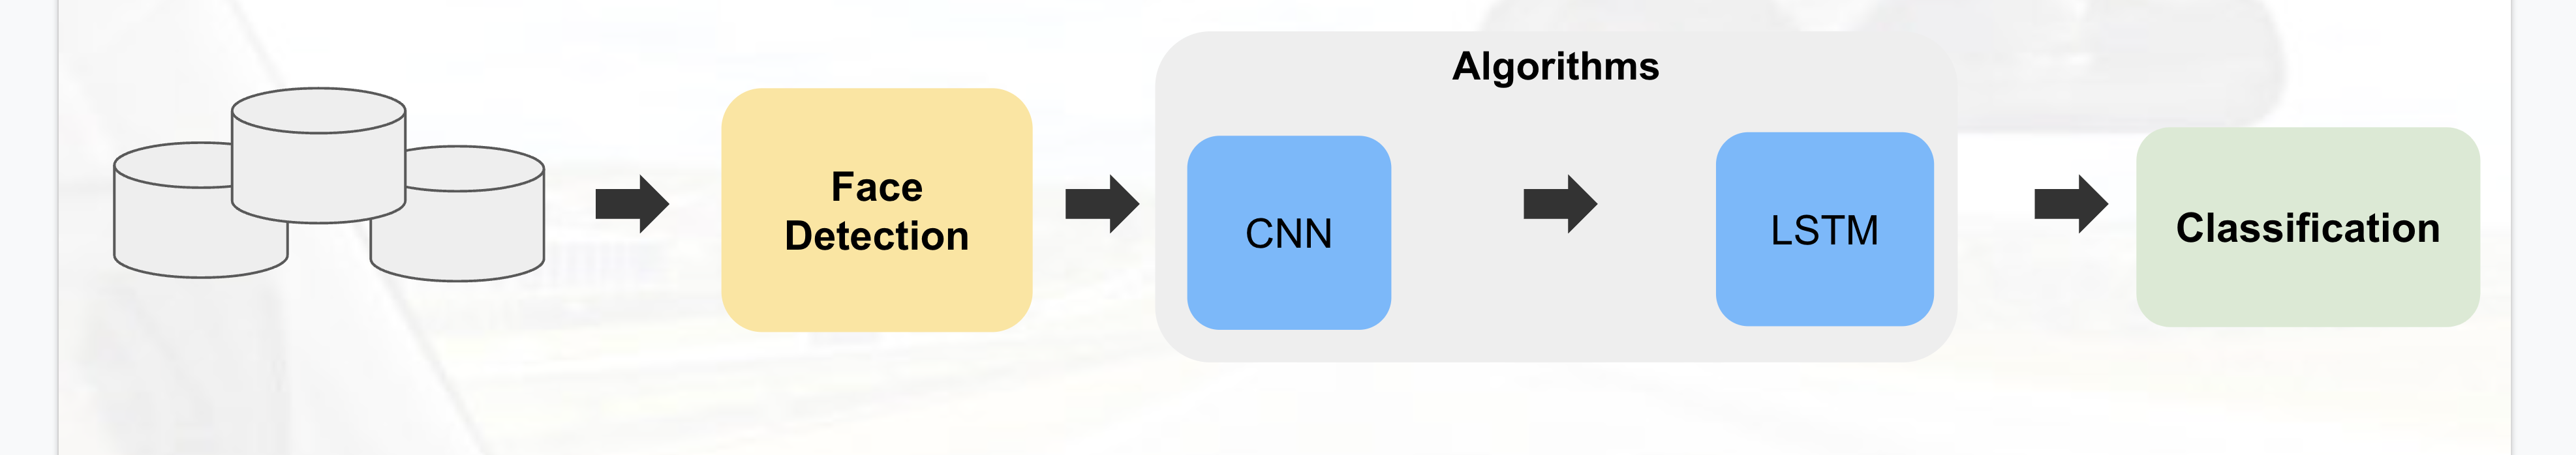


# Team : 
Abby Bai, Saman Arabali, Sri Yanamandra, Tony Hwang, Amey Mahajan


# References : Code Repos and Literature

- https://medium.com/@jaynishvaghela/driver-drowsiness-detection-using-lstm-network-2966c49a5400
- https://github.com/jaynishvaghela/DriverDrowsinessDetection
- https://github.com/nishagandhi/DrowsyDriverDetection

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import files
from google.colab import drive
import os
import pickle

drive.mount('/drive', force_remount=True)

google_drive_folder = '/drive/MyDrive/temporal/'

Mounted at /drive


# Import packages

In [ ]:
!pip install opencv-python


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import pickle
import imutils
import os
import cv2
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os.path
import csv
import glob
import tensorflow as tf
import h5py as h5py
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
import natsort
import sys
import shutil
from scipy.sparse.construct import random
import random as rndm
from concurrent.futures import ProcessPoolExecutor


# Helper Functions : Data preparation, loading and extracting frames from videos, filesystem manipulation

In [ ]:
face_cascade = cv2.CascadeClassifier(google_drive_folder+'haarcascade_frontalface_default.xml')
img = 1000

def load_video(datasets):
    global image
    labels=[]
    images=[]
    outputFolderPath = "/drive/MyDrive/temporal/" + "Output/"
    #Iterate through each foler corresponding to category
    for folders in os.scandir(datasets):
      if folders.is_dir() and not "Fold1" in folders.path:
        print("============================= Working on Folder " + folders.path + "=============================")
        
        if os.path.exists(outputFolderPath):
          pass
        else:
          os.makedirs(outputFolderPath)
        for folder in os.scandir(folders):
          if folder.is_dir():
            for file in tqdm(os.listdir(folder)):
              if os.path.isdir(folder.path + "/" + file):
                print(file)
                os.rmdir(folder.path + "/" + file)
                print("Removed")
              #Get the path name for each video
              label_int = int(file.split(".")[0])
              video_path = os.path.join(folder, file)
              #Extract the frames of the current video
              frames_list = feature_extraction(video_path, folders.path, folder, label_int)
              images.append(frames_list)
              if label_int == 0:
                labels.append(0) #Alert
              # elif label_int == 5:
              #   labels.append(1) #low vigilant
              else:
                labels.append(1) #DROWSY
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')
    
def detect_one_face(im):
    gray=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.2, 3)
    if len(faces) == 0:
        return (0,0,0,0)
    return faces[0]
def hsv_histogram_for_window(frame, window):
    # set up the ROI for tracking
    c,r,w,h = window
    roi = frame[r:r+h, c:c+w]
    hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
    roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
    cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
    return roi_hist


#Function for Feature Extraction
def feature_extraction(video_path, partVideoFolder, videoFolder, labelIndicator):
    width=128
    height=128
    sequence_length=10
    frames_list=[]
    if labelIndicator == 0:
      ext = "Alert"
    else:
      ext = "Drowsy"
    outputFPath = "/drive/MyDrive/temporal/" + "Output/" + partVideoFolder.split("/")[-1] + "/" + videoFolder.path.split("/")[-1]
    outputVideoFolderPath = os.path.join(outputFPath, ext)
    if os.path.exists(outputVideoFolderPath):
      pass
    else:
      os.makedirs(outputVideoFolderPath)

    output_n = "facial_features.txt"
    data = open(os.path.join(outputVideoFolderPath,output_n),"w")
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        if not ret:
            break;

        frameCounter = 0
        c,r,w,h = detect_one_face(frame)
        pt = (0,c+w/2,r+h/2)

        data.write("%d,%d,%d\n" % pt)
        frameCounter =+1
        track_window = (c,r,w,h)

        try:
          roi_hist = hsv_histogram_for_window(frame, (c,r,w,h))
          count = 0
          term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
          clip = rndm.randint(1500,3000)

          cnt = clip
          while(1):
              ret ,frame = video_reader.read()
              cnt+=1
              if ret == False:
                  break
              
              if cnt <= clip + img:
                  hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
                  dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
                  ret, track_window = cv2.CamShift(dst, track_window, term_crit)
                  x,y,w,h = track_window
                  # write the result to the data file
                  pt = (frameCounter,x+w/2,y+h/2)
                  data.write("%d,%d,%d\n" % pt) # Write as frame_index,pt_x,pt_y
                  cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
                  try:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    roi_gray = gray[y:y+h, x:x+w]
                    roi_color = frame[y:y+h, x:x+w]

                    croppedImg = roi_color
                    if(croppedImg.shape[0]<=0 or croppedImg.shape[1]<=0):
                        frameCounter = frameCounter + 1
                        continue
                    data_name = outputVideoFolderPath+"/"+str(frameCounter)+".jpg"
                    cv2.imwrite(data_name, croppedImg)
                    k = cv2.waitKey(1) & 0xff
                    if k == 27:
                        break
                    frameCounter = frameCounter + 1
                  except:
                    continue
              else:
                  break
        except:
          continue
    video_reader.release()
    #Return the Frames List
    return frames_list

def extractor(image_path):

	with open(google_drive_folder+'output_graph2.pb', 'rb') as graph_file:
		graph_def = tf.compat.v1.GraphDef()
		graph_def.ParseFromString(graph_file.read())
		tf.import_graph_def(graph_def, name='')

	with tf.compat.v1.Session() as sess:
	    pooling_tensor = sess.graph.get_tensor_by_name('pool_3:0')
	    #tf.compat.v2.io.gfile.GFile()
	    image_data = tf.compat.v1.gfile.FastGFile(image_path, 'rb').read()	
	    pooling_features = sess.run(pooling_tensor, \
	    	{'DecodeJpeg/contents:0': image_data})
	    pooling_features = pooling_features[0]

	return pooling_features

def copyToModelInput(listToCopy,flag, trainTestFlag):

  if trainTestFlag == 0: #Train:
    output_drowsy = "/drive/MyDrive/temporal/InceptionModelInput/Training/Drowsy/"
    output_alert =  "/drive/MyDrive/temporal/InceptionModelInput/Training/Alert/"
  else:
    output_drowsy = "/drive/MyDrive/temporal/InceptionModelInput/Testing/Drowsy/"
    output_alert =  "/drive/MyDrive/temporal/InceptionModelInput/Testing/Alert/"
  for paths in tqdm(listToCopy):
    if flag == 0:#Drowsy
      dest = output_drowsy + paths.split("/")[-4]+"_"+paths.split("/")[-3] + "_Drowsy_"+paths.split("/")[-1]
      # print(dest)
    elif flag ==1:
      dest = output_alert + paths.split("/")[-4]+"_"+paths.split("/")[-3] + "_Alert_"+paths.split("/")[-1]
      # print(dest)
    # with ProcessPoolExecutor(4) as exe:
    #     # submit all copy tasks
    # print(paths, dest)
    # break
    copyFile(paths, dest)
  print("Image Transfer Done..")


def copyFile(src, dest):
  shutil.copy2(src,dest)

def getRandomTrainTestPaths():
  final_drowsy_list = []
  final_alert_list = []
  for folders in os.scandir("/drive/MyDrive/temporal/Output/"):
    for folders2 in os.scandir(folders):
      for subfolders in os.scandir(folders2):
        if subfolders.name == "Drowsy":
          final_drowsy_list.extend(getPathList(subfolders))
        elif subfolders.name == "Alert":
          final_alert_list.extend(getPathList(subfolders))
  
  sampling_point = int(0.7*len(final_drowsy_list))
  rndm.shuffle(final_drowsy_list)
  drowsy_train = final_drowsy_list[:sampling_point]
  drowsy_test = final_drowsy_list[sampling_point:]

  sampling_point_alert = int(0.7*len(final_alert_list))
  rndm.shuffle(final_alert_list)
  alert_train = final_alert_list[:sampling_point_alert]
  alert_test = final_alert_list[sampling_point_alert:]
  
  return drowsy_train, drowsy_test, alert_train, alert_test  


def getPathList(folderToScan):
  listToAdd = []
  for file in glob.glob(os.path.join(folderToScan.path,"*.jpg")):
    listToAdd.append(file)
  return listToAdd

# Following sections go through data preparation & cleanup

In [ ]:
drowsy_path = google_drive_folder + 'drowsy_input/'
# for folders in os.scandir(drowsy_path):
#   if folders.is_dir():
images, labels = load_video(drowsy_path)
print(images.shape, labels.shape)

In [ ]:
dtrain, dtest, atrain, atest = getRandomTrainTestPaths()
len(dtrain), len(dtest), len(atrain), len(atest)

(40600, 17400, 37100, 15900)

In [1]:
copyToModelInput(dtrain,0,0)
copyToModelInput(atrain,flag=1,trainTestFlag=0)
copyToModelInput(dtest,flag=0,trainTestFlag=1)
copyToModelInput(atest,1,1)

# Transfer Learning : CNN Inception V3 training on Alert and Drowsy Videos

In [ ]:
!python /drive/MyDrive/temporal/transfer_learning.py --output_graph=/drive/MyDrive/temporal/output_graph2.pb --output_labels=/drive/MyDrive/temporal/output_labels.txt --image_dir=/drive/MyDrive/temporal/InceptionModelInput/Training/

In [ ]:
trainPath = "/drive/MyDrive/temporal/InceptionModelInput/Training"
outputPath = "/drive/MyDrive/temporal/Output/"
sequencePath = "/drive/MyDrive/temporal/SequenceOutput/newTraining/FullTraining"

trainFilesForExtraction = []
for folders in os.scandir(trainPath):
  for imageFiles in os.scandir(folders):
    # print(imageFiles)
    split = imageFiles.name.split("_")
    first_path = split[0] + "_" + split[1]
    second_path = split[2]
    third_path = split[3]
    # fourth_path = split[4]
    pathToAppend = os.path.join(outputPath, first_path, second_path, third_path,"*.jpg")
    if pathToAppend in trainFilesForExtraction:
      continue
    else:  
      trainFilesForExtraction.append(pathToAppend)

seq = 50
for f in tqdm(trainFilesForExtraction):
  # if (not "Fold1_part1" in f) and (not "Fold1_part2" in f):
  frames = glob.glob(f)
  frames  = natsort.natsorted(frames,reverse=False)
  sequence = []
  split = f.split("/")
  first_path = split[-4]
  second_path = split[-3]
  third_path = split[-2]
  cnt = 0
  if os.path.exists(os.path.join(sequencePath, first_path+"_"+second_path+"_"+third_path+"_"+str(50)+'-features.npy')) or os.path.exists(os.path.join(sequencePath, first_path+"_"+second_path+"_"+third_path+"_"+str(100)+'-features.npy')):
    print("here")
    continue
  for image in frames:
    with tf.Graph().as_default():
      features = extractor(image)
      cnt+=1
      sequence.append(features)
      seqPath = os.path.join(sequencePath, first_path+"_"+second_path+"_"+third_path+"_"+str(cnt)+'-features.npy')
    if cnt % seq == 0:
      np.save(seqPath,sequence)
      # print('Sequences saved successfully')
      sequence = []
    if int(cnt/seq) == 2:
      break
